# Emsembling - Titanic

Updated
- random forest

Upcoming Update
- extra tree
- ada boost
- gradient boost
- svc

## Import Library

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Data

### Find Path and Load Data

In [2]:
import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/test.csv
./data/train.csv
./data/gender_submission.csv


In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
train_df.shape, test_df.shape

((891, 12), (418, 11))

## EDA

Save passenger Id for submission file

In [4]:
PassengerId = test_df['PassengerId']
PassengerId

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [5]:
train_df['Cabin'], type(train_df['Cabin'][0]), type(train_df['Cabin'][1])

(0       NaN
 1       C85
 2       NaN
 3      C123
 4       NaN
        ... 
 886     NaN
 887     B42
 888     NaN
 889    C148
 890     NaN
 Name: Cabin, Length: 891, dtype: object,
 float,
 str)

'Cabin' 
- If Passenger had a cabin, value is in str type.
- Else, value is in float.
- Change values to 1, 0

In [6]:
combine = [train_df, test_df]

for dataset in combine:
    dataset['Cabin'] = dataset['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

'FamilySize'
- Count 'SibSp', 'Parch', and self

In [7]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

'IsAlone'
- If Passenger is alone 1, else 0
- use 'FamilySize'

In [8]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

'Embarked'
- fill missing values with most common 'Embarked' value(which is 'S')
- categorization 

<Axes: xlabel='Embarked', ylabel='count'>

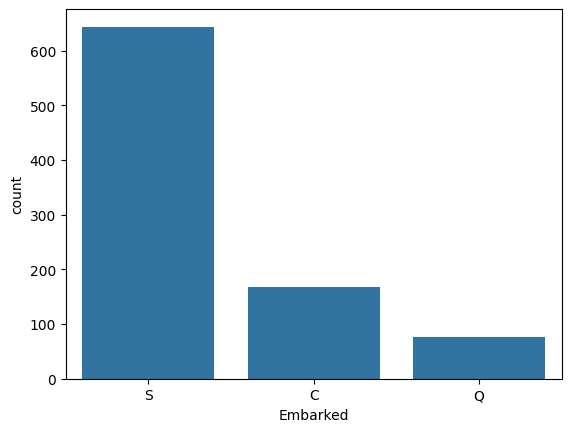

In [9]:
sns.countplot(x='Embarked', data=train_df)

In [10]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [11]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)


'Fare'
- fill missing values with the average 'Fare' for each 'Pclass'
- 'Fare' values are affected by class
- cut into 4 categories

<Axes: xlabel='Pclass', ylabel='Fare'>

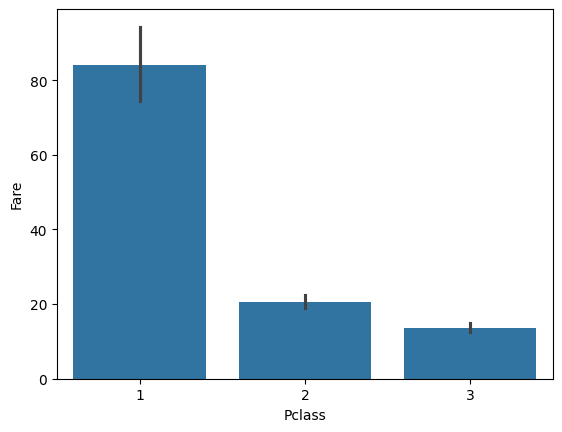

In [12]:
sns.barplot(x='Pclass', y='Fare', data=train_df)

In [13]:
fare_mean_by_class = train_df['Fare'].groupby(train_df['Pclass']).mean()
fare_mean_by_class

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

In [14]:
for dataset in combine:
    dataset['Fare'] = dataset['Fare'].fillna(train_df['Pclass'].map(fare_mean_by_class))

In [15]:
train_df['Fare'].describe(include=0)

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

<Axes: xlabel='Fare', ylabel='Survived'>

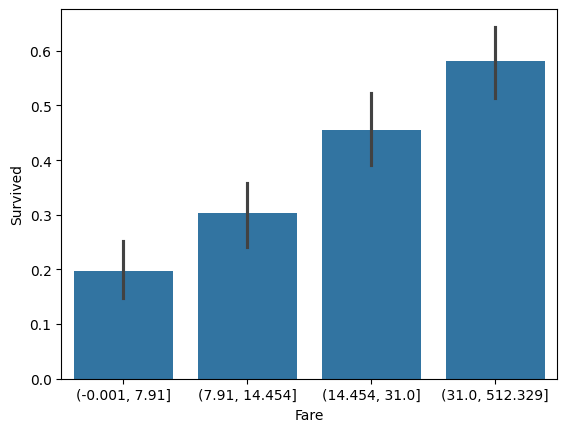

In [16]:
sns.barplot(x=pd.qcut(train_df['Fare'], 4), y=train_df['Survived'], data=train_df)

In [17]:
train_df['CatFare'] = pd.qcut(train_df['Fare'], 4)

In [18]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

'Age'
- fill missing values with the average 'Age' for each 'Pclass'
- 'Age' values are affected by class
- cut into 5 categories

In [19]:
age_mean_by_class = train_df['Age'].groupby(train_df['Pclass']).mean().round()
age_mean_by_class


Pclass
1    38.0
2    30.0
3    25.0
Name: Age, dtype: float64

In [20]:
for dataset in combine:
    dataset['Age'] = dataset['Age'].fillna(train_df['Pclass'].map(age_mean_by_class))

<Axes: xlabel='Age', ylabel='Survived'>

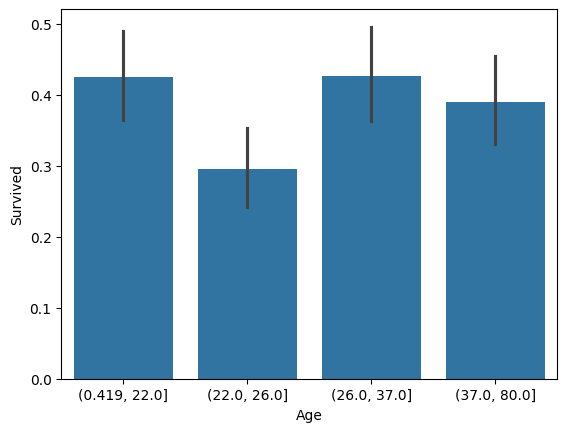

In [21]:
sns.barplot(x=pd.qcut(train_df['Age'], 4), y=train_df['Survived'], data=train_df)

<Axes: xlabel='Age', ylabel='Survived'>

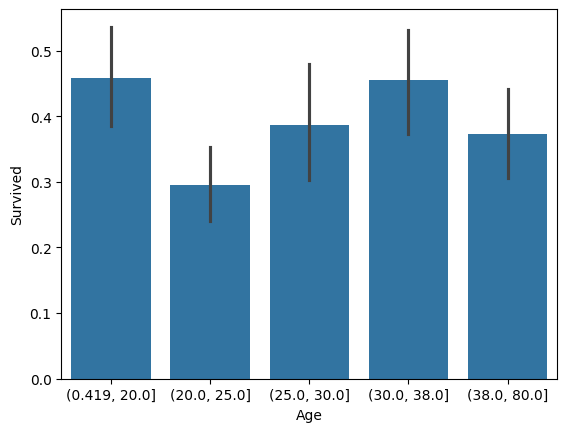

In [22]:
sns.barplot(x=pd.qcut(train_df['Age'], 5), y=train_df['Survived'], data=train_df)

In [23]:
train_df['CatAge'] = pd.cut(train_df['Age'], 5)

In [24]:
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

'Title'
- Get title from name
- Categorization by meaning

In [25]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)


In [26]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [27]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,CatFare,CatAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,0,0,0,2,0,"(-0.001, 7.91]","(16.336, 32.252]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,3,1,1,2,0,"(31.0, 512.329]","(32.252, 48.168]",3
2,3,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,STON/O2. 3101282,1,0,0,1,1,"(7.91, 14.454]","(16.336, 32.252]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,3,1,0,2,0,"(31.0, 512.329]","(32.252, 48.168]",3
4,5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,1,0,0,1,1,"(7.91, 14.454]","(32.252, 48.168]",1


'Sex'
- female : 1, male : 0

In [28]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)


### Select features

In [29]:
drop_features = ['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch']

for dataset in combine:
    dataset.drop(drop_features, axis=1, inplace=True)

In [30]:
train_df = train_df.drop(['CatAge', 'CatFare'], axis=1)

In [31]:
train_df


,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,FamilySize,IsAlone,Title
0,0,3,0,1.0,0,0,0,2,0,1
1,1,1,1,2.0,3,1,1,2,0,3
2,1,3,1,1.0,1,0,0,1,1,2
3,1,1,1,2.0,3,1,0,2,0,3
4,0,3,0,2.0,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,1.0,1,0,0,1,1,5
887,1,1,1,1.0,2,1,0,1,1,2
888,0,3,1,1.0,2,0,0,4,0,2
889,1,1,0,1.0,2,1,1,1,1,1


In [32]:
test_df

,Pclass,Sex,Age,Fare,Cabin,Embarked,FamilySize,IsAlone,Title
0,3,0,2.0,0,0,2,1,1,1
1,3,1,2.0,0,0,0,2,0,3
2,2,0,3.0,1,0,2,1,1,1
3,3,0,1.0,1,0,0,1,1,1
4,3,1,1.0,1,0,0,3,0,3
...,...,...,...,...,...,...,...,...,...
413,3,0,1.0,1,0,0,1,1,1
414,1,1,2.0,3,1,1,1,1,5
415,3,0,2.0,0,0,0,1,1,1
416,3,0,1.0,1,0,0,1,1,1


### Visualisation

Using pearson correlation heatmap

If pearson correlation value is near -1 and 1, two features are strongly correlated with each other.

<Axes: title={'center': 'Pearson Correalation of Features'}>

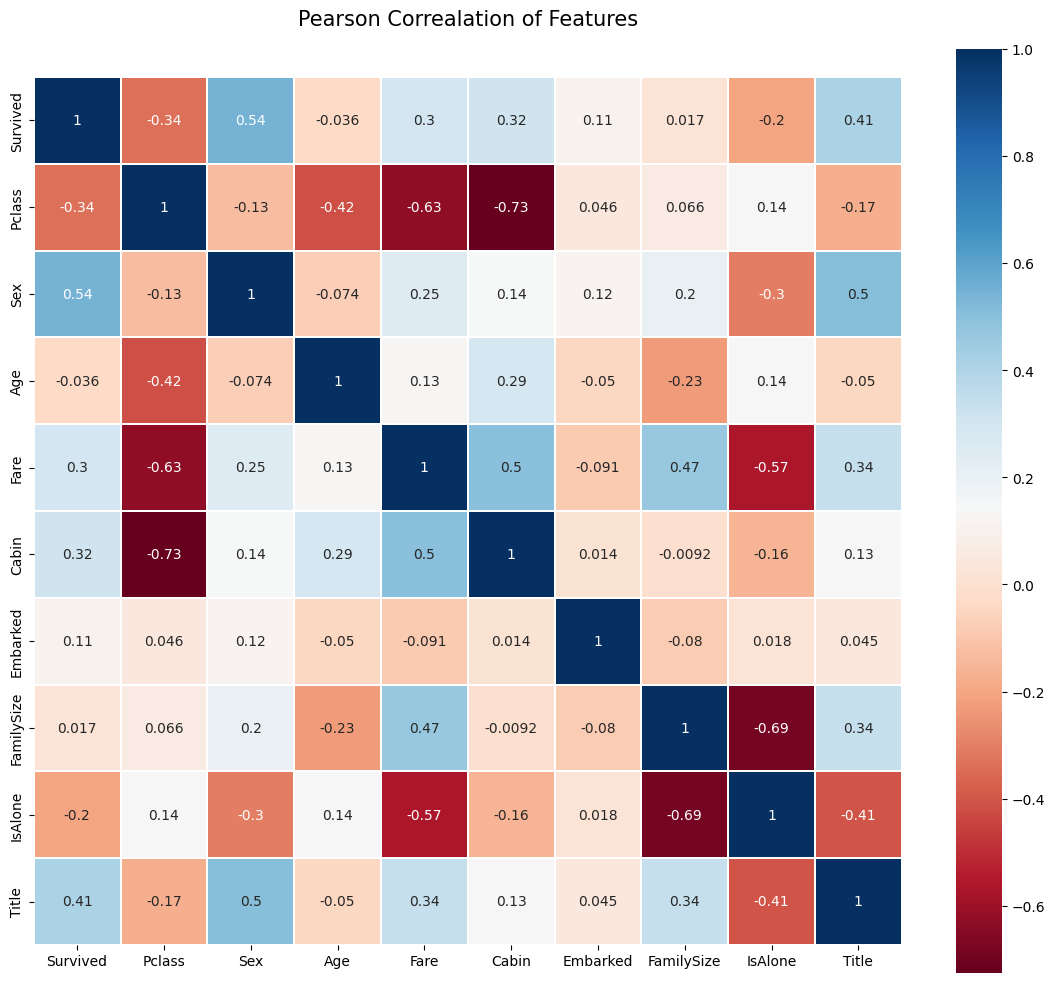

In [33]:
cmap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correalation of Features', y=1.05, size=15)
sns.heatmap(train_df.astype(float).corr(),
            linewidths=0.1,
            vmax=1.0,
            square=True,
            cmap=cmap,
            linecolor='white',
            annot=True,
            )

Using pairplots to observe the distribution of data from one feature to another.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector,

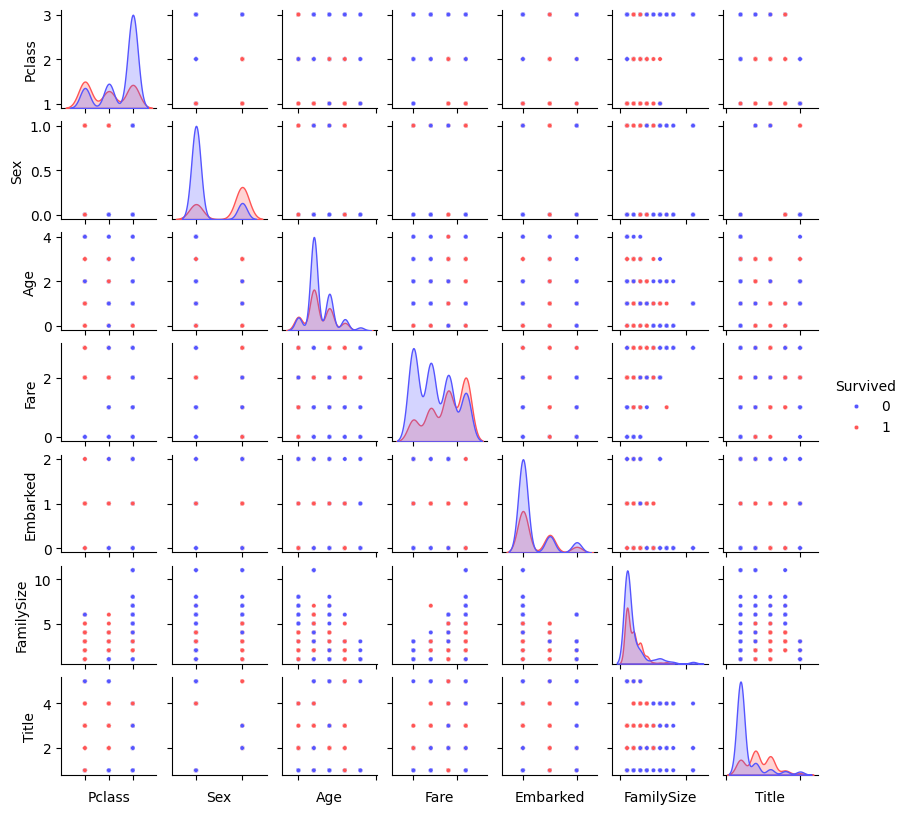

In [34]:
g = sns.pairplot(train_df[[u'Survived', u'Pclass', u'Sex', u'Age', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])


## Ensemble Models

### Random Forest

#### Advantage of Random Forest
- Available for both of classification, regression problems
- Easy to deal with missing values
- Efficient with big size data
- Avoid overfitting, increase accuracy
- In classification model, We can choose relatively important feature(Ranking)

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
# split train and test data

X_train = train_df.drop('Survived', axis=1)
Y_train = train_df['Survived']
X_test = test_df

# create classifier
random_forest = RandomForestClassifier(n_estimators=100)

# train
random_forest.fit(X_train, Y_train)

# predict
Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
accuracy = round(random_forest.score(X_train, Y_train) * 100, 2)

accuracy

89.34

In [37]:
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": Y_pred
    })
submission.to_csv('./submit/04_ensembling.csv', index=False)